In [13]:
# -----------------------------
# Import Libraries
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# -----------------------------
# Load Dataset
# -----------------------------
df = pd.read_csv('/content/Telco-Customer-Churn.csv')

# -----------------------------
# Drop unnecessary columns if present
# -----------------------------
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)

# -----------------------------
# Handle missing values
# -----------------------------
# Convert TotalCharges to numeric
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df.dropna(subset=['TotalCharges'], inplace=True)

# -----------------------------
# Encode Binary Features
# -----------------------------
binary_cols = ['gender','Partner','Dependents','PhoneService','PaperlessBilling','Churn']
binary_cols = [col for col in binary_cols if col in df.columns]

le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# -----------------------------
# Encode Multi-category Features
# -----------------------------
multi_cat_cols = ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies',
                  'Contract','PaymentMethod']
existing_multi_cat_cols = [col for col in multi_cat_cols if col in df.columns]

df = pd.get_dummies(df, columns=existing_multi_cat_cols, drop_first=True)  # drop_first avoids dummy variable trap

# -----------------------------
# Feature Scaling for Numeric Columns
# -----------------------------
numeric_cols = ['tenure','MonthlyCharges','TotalCharges']
existing_numeric_cols = [col for col in numeric_cols if col in df.columns]

scaler = StandardScaler()
df[existing_numeric_cols] = scaler.fit_transform(df[existing_numeric_cols])

# -----------------------------
# Separate Features and Target
# -----------------------------
if 'Churn' in df.columns:
    X = df.drop('Churn', axis=1)
    y = df['Churn']
else:
    X = df.copy()
    y = None

# -----------------------------
# Split Data (optional)
# -----------------------------
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [14]:
from sklearn.model_selection import train_test_split

# First split: Train + Temp (Temp will later be split into Validation and Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Second split: Validation and Test (from Temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Display sizes
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Training set: (4922, 30), Validation set: (1055, 30), Test set: (1055, 30)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# -----------------------------
# Build ANN Model
# -----------------------------
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# -----------------------------
# Train the model
# -----------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1
)

# -----------------------------
# Evaluate on Test Set
# -----------------------------
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=['No Churn','Churn'])

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6876 - loss: 0.5560 - val_accuracy: 0.8190 - val_loss: 0.4234
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7875 - loss: 0.4479 - val_accuracy: 0.8152 - val_loss: 0.4142
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7926 - loss: 0.4271 - val_accuracy: 0.8076 - val_loss: 0.4127
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7957 - loss: 0.4348 - val_accuracy: 0.8209 - val_loss: 0.4123
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8010 - loss: 0.4264 - val_accuracy: 0.8218 - val_loss: 0.4125
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7921 - loss: 0.4259 - val_accuracy: 0.8123 - val_loss: 0.4147
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7932 - loss: 0.4259 - val_accuracy: 0.8256 - val_loss: 0.4137
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8012 - loss: 0.4273 - val_accuracy: 0

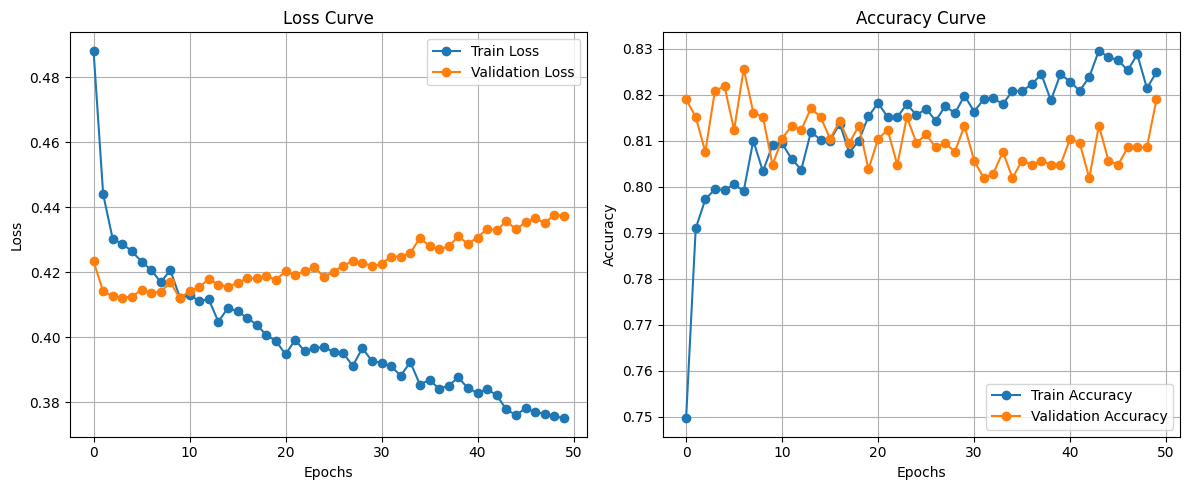

In [16]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Training & Validation Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predict probabilities and convert to binary labels
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
report = classification_report(y_test, y_pred, target_names=['No Churn', 'Churn'])
print("\nClassification Report:\n", report)

# Individual metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Churn Class Precision: {precision:.2f}")
print(f"Churn Class Recall: {recall:.2f}")
print(f"Churn Class F1-score: {f1:.2f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix:
 [[689  86]
 [151 129]]

Classification Report:
               precision    recall  f1-score   support

    No Churn       0.82      0.89      0.85       775
       Churn       0.60      0.46      0.52       280

    accuracy                           0.78      1055
   macro avg       0.71      0.67      0.69      1055
weighted avg       0.76      0.78      0.77      1055

Test Accuracy: 0.78
Churn Class Precision: 0.60
Churn Class Recall: 0.46
Churn Class F1-score: 0.52
